# Лабораторная работа №4. Корреляционный анализ

> Вариант № 1

**Распределения**:

$X \sim N(1, 2)$

$Y \sim R(-1, 1)$

Объём выборок $n$ &mdash; 100


In [16]:
%matplotlib inline
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# Немного магии для того, чтобы рисунки стали больше
import pylab
pylab.rcParams['figure.figsize'] = (24.0, 16.0)
plt.rcParams.update({'font.size': 22})

# Вспомогательные классы и функции, определённые тут же (см. репозиторий)
# https://github.com/BobNobrain/matstat-labs/tree/master/s
from s import Sample, HTable
from s.utils import table, printf, load_styles

## 1. Исходные данные

In [18]:
X = stats.norm(1, 2)
Y = stats.uniform(-1, 2)
n = 100

print('Характеристики наблюдаемых случайных величин:')
table(
    ['СВ', 'Распределение', 'Параметры', '$m_i$', '$\\sigma_i^2$', '$n_i$'],
    [
        ['X', 'N', '$m=1, \\sigma=2$', X.mean(), X.var(), n],
        ['Y', 'R', '$a=-1, b=1$', Y.mean(), Y.var(), n]
    ]
)

Характеристики наблюдаемых случайных величин:


СВ,Распределение,Параметры,$m_i$,$\sigma_i^2$,$n_i$
X,N,"$m=1, \sigma=2$",1.0,4.0,100
Y,R,"$a=-1, b=1$",0.0,0.3333333333333333,100


In [19]:

x = Sample.from_distribution("x", X, count=n)
y = Sample.from_distribution("y", Y, count=n)
print('Выборочные характеристики:')
table(
    ['СВ', 'Среднее $\\overline{x_i}$', '$s^2_i$', '$s_i$'],
    [
        [
            s._name,
            round(s.mean(), 4),
            round(s.s() ** 2, 4),
            round(s.s(), 4)
        ] for s in [x, y]
    ]
)

Выборочные характеристики:


СВ,Среднее $\overline{x_i}$,$s^2_i$,$s_i$
x,0.9979,3.6459,1.9094
y,0.0035,0.3729,0.6107


In [20]:
def pierson(x, y):
    return stats.pearsonr(x.data() ,y.data())[0]
def spirmen(x, y):
    return stats.spearmanr(x.data() ,y.data())[0]
def kendell(x, y):
    return stats.kendalltau(x.data() ,y.data())[0]

In [21]:
t = HTable(rows=2, cols=6, head_rows=1)
t.fill(row=0, head=True, content=[
    'СВ',
    'Среднее $\\overline{x_i}$',
    'Оценка дисперсии $s^2_i$',
    'КК по Пирсону $r_{xy}$',
    'КК по Спирмену $\\rho_{xy}$',
    'КК по Кендаллу $\\tau_{xy}$'
])
t.fill(col=0, content=['X', 'Y'])
t.map_col(0, lambda c: c.add_class('head'))
t.fill(col=1, content=[
    round(sample.mean(), 4)        for sample in [x, y]
])
t.fill(col=2, content=[
    round(sample.s() ** 2, 4)      for sample in [x, y]
])

t.map_row(0, lambda c: c.span(rowspan=2).add_class('text-center'), limits=(3, 6))

t.fill(row=0, content=[
    None,
    None,
    None,
    pierson(x, y),
    spirmen(x, y),
    kendell(x, y)
])

print('Выборочные характеристики:')
t.show()


Выборочные характеристики:


In [22]:
print('Проверка значимости коэффициентов корреляции:')

alpha = 0.05

#PS = stats.t(n-2).ppf(1-alpha/2)
#K =  stats.normal(0,1).ppf(1-alpha/2)

K = stats.kendalltau(x.data() ,y.data())[1]
P = stats.pearsonr(x.data() ,y.data())[1]
S = stats.spearmanr(x.data() ,y.data())[1]

def decision(a, p) :
    if p>a:
        return "H0"
    else:
        return "H1"

K_d = decision(alpha, K)
P_d = decision(alpha, P)
S_d = decision(alpha, S)

def iserr(str):
    if str == "H0":
        return "нет ошибки"
    else :
        return "ошибка первого рода"
    

table(
    [
        'Статистическая гипотеза $H_0$',
        'p-value',
        'Статистическое решение при $\\alpha={}$'.format(alpha),
        'Ошибка статистического решения'
    ],
    [
        ['$H_0: r_{XY} = 0$', S, S_d, iserr(S_d)],
        ['$H_0: \\rho_{XY} = 0$', P, P_d, iserr(P_d)],
        ['$H_0: \\tau_{XY} = 0$', K, K_d, iserr(K_d)]
    ]
)

Проверка значимости коэффициентов корреляции:


Статистическая гипотеза $H_0$,p-value,Статистическое решение при $\alpha=0.05$,Ошибка статистического решения
$H_0: r_{XY} = 0$,0.9831710044528079,H0,нет ошибки
$H_0: \rho_{XY} = 0$,0.7378800965461589,H0,нет ошибки
$H_0: \tau_{XY} = 0$,0.9240767513856051,H0,нет ошибки


## 2. Визуальное представление двумерной выборки

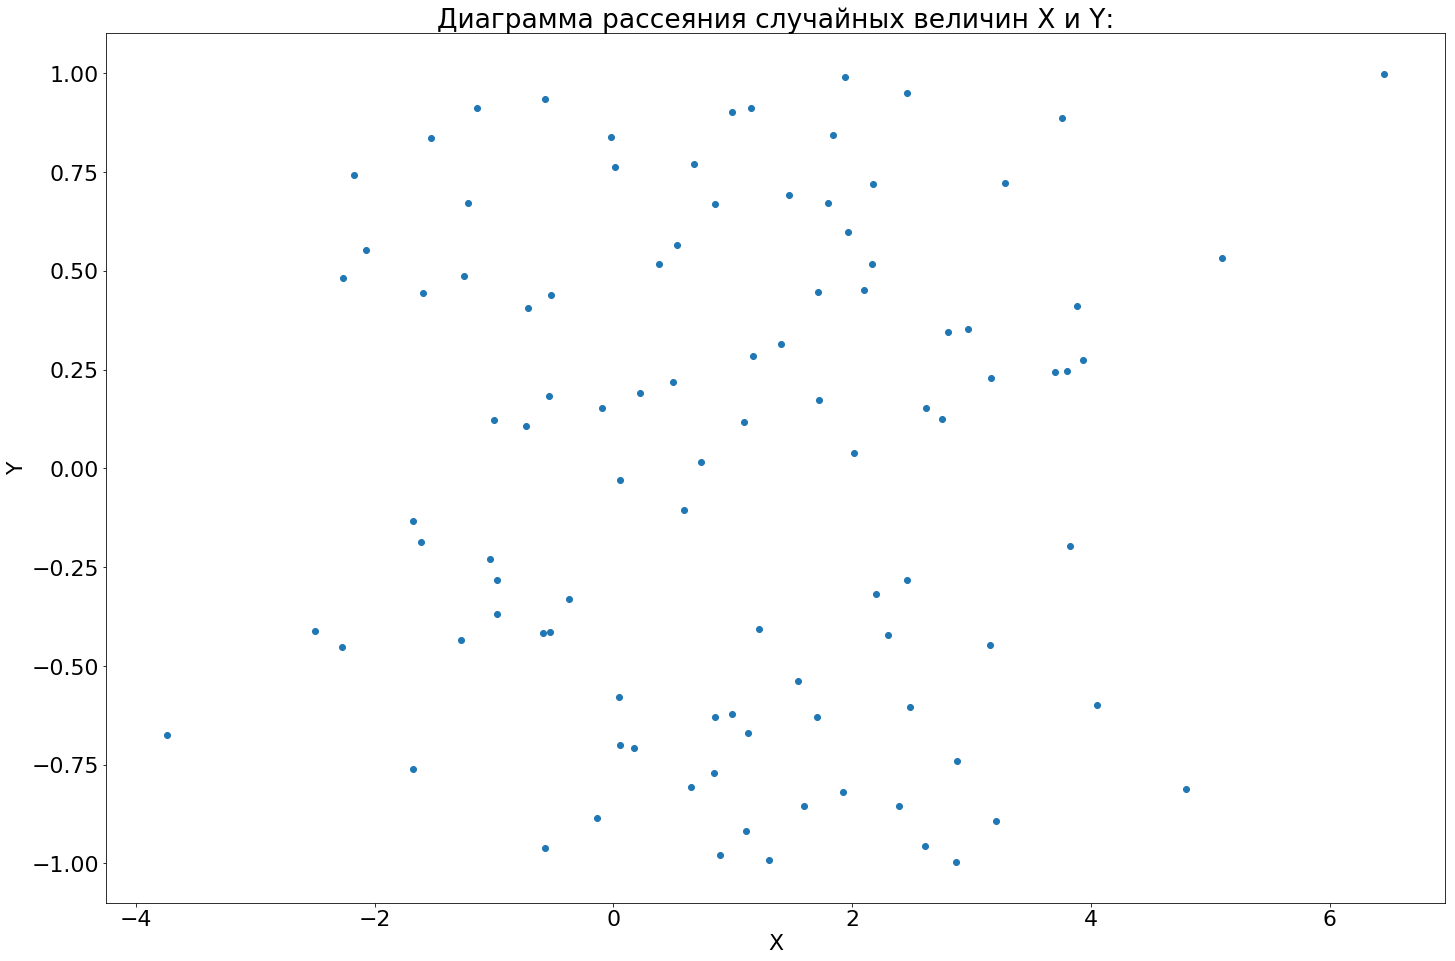

In [23]:
fig, ax = plt.subplots()

ax.set_title('Диаграмма рассеяния случайных величин X и Y:')
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax.scatter(x.data(), y.data())


# параметр s=? используется для задания размера маркеров
# ax.scatter( ... );


## 3. Проверка независимости методом таблиц сопряженности

Статистическая гипотеза:

$$ H_0: F_Y(y | X \in \Delta_1) = ... = F_Y(y | X \in \Delta_k) = F_Y(y) $$

In [24]:
print('Эмпирическая таблица сопряженности:')

def choose_cell1 (a):
    if   -4.0 <= a < -2.0:
        return 0
    elif -2.0 <= a < 0.:
        return 1
    elif 0. <= a < 2.:
        return 2
    elif 2. <= a < 4.:
        return 3
    elif 4. <= a <= 6.:
        return 4
    else :
        return -1

def choose_cell (a):
    if   -1.0 <= a < -0.6:
        return 0
    elif -0.6 <= a < -0.2:
        return 1
    elif -0.2 <= a < 0.2:
        return 2
    elif 0.2 <= a < 0.6:
        return 3
    elif 0.6 <= a <= 1.0:
        return 4
    else :
        return -1
    

table_values = np.zeros((5,5))
for i in range(x.n()):
    a=choose_cell1(x.data()[i])
    b=choose_cell(y.data()[i])
    table_values[a][b] = table_values[a][b] + 1  
table_row_names = []
adge = -4.
for i in range(5):
    adge+=2.
    table_row_names.append('$\\Delta_1 = [{};{})$'.format(str(round(adge-2., 1)),' '+str(round(adge,1))) )


table(
    [
        'X \\ Y',
        '[{};{})'.format('-1', ' -0.6'),
        '[{};{})'.format('-0.6', ' -0.2'),
        '[{};{})'.format('-0.2', ' 0.2'),
        '[{};{})'.format('0.2', ' 0.6'),
        '[{};{}]'.format('0.6', ' 1')
    ],
    [
        [table_row_names[i]] + table_values[i].tolist() for i in range(5)
    ]
)


def mij (i, j):
    sum1, sum2 = 0, 0
    for a in range(5):
        sum1 = sum1 + table_values[a, j]
        sum2 = sum2 + table_values[i, a]
    return (sum1 * sum2)/n
print(x.n())

th_values = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        th_values[i][j] = mij(i,j)

print('теоретическая таблица сопряженности:')

table(
    [
        'X \\ Y',
        '[{};{})'.format('-1', ' -0.6'),
        '[{};{})'.format('-0.6', ' -0.2'),
        '[{};{})'.format('-0.2', ' 0.2'),
        '[{};{})'.format('0.2', ' 0.6'),
        '[{};{}]'.format('0.6', ' 1')
    ],
    [
        [table_row_names[i]] + th_values[i].tolist() for i in range(5)
    ]
)
print (table_values.sum(), th_values.sum())
x = Sample.from_distribution("x", X, count=100)
y = Sample.from_distribution("y", Y, count=100)

Эмпирическая таблица сопряженности:


X \ Y,[-1; -0.6),[-0.6; -0.2),[-0.2; 0.2),[0.2; 0.6),[0.6; 1]
$\Delta_1 = [-4.0; -2.0)$,1.0,2.0,0.0,2.0,1.0
$\Delta_1 = [-2.0; 0.0)$,3.0,7.0,6.0,4.0,5.0
$\Delta_1 = [0.0; 2.0)$,13.0,3.0,6.0,7.0,9.0
$\Delta_1 = [2.0; 4.0)$,6.0,4.0,4.0,9.0,4.0
$\Delta_1 = [4.0; 6.0)$,1.0,1.0,0.0,1.0,1.0


100
теоретическая таблица сопряженности:


X \ Y,[-1; -0.6),[-0.6; -0.2),[-0.2; 0.2),[0.2; 0.6),[0.6; 1]
$\Delta_1 = [-4.0; -2.0)$,1.44,1.02,0.96,1.38,1.2
$\Delta_1 = [-2.0; 0.0)$,6.0,4.25,4.0,5.75,5.0
$\Delta_1 = [0.0; 2.0)$,9.12,6.46,6.08,8.74,7.6
$\Delta_1 = [2.0; 4.0)$,6.48,4.59,4.32,6.21,5.4
$\Delta_1 = [4.0; 6.0)$,0.96,0.68,0.64,0.92,0.8


100.0 99.99999999999999


In [25]:
alpha = 0.05 
z = 0
for i in range(5):
    for j in range(5):
        z = z + (((table_values[i, j] - th_values[i, j])**2)/th_values[i, j])

p = 1 - stats.chi2(16).cdf(z) #right p-value
d = decision(alpha, p)
        

table(
    [
        'Выборочное значение статистики критерия',
        'p-value',
        'Статистическое решение при $\\alpha={}$'.format(alpha),
        'Ошибка статистического решения'
    ],
    [
        [z, p, d, iserr(d)]
    ]
)

Выборочное значение статистики критерия,p-value,Статистическое решение при $\alpha=0.05$,Ошибка статистического решения
13.86991357692327,0.6084044741422358,H0,нет ошибки


## 4. Исследование корреляционной связи

Случайная величина $ U = \lambda X + (1 - \lambda) Y, \lambda \in [0; 1]$

Случайная величина $ V = \lambda X^3 + (1 - \lambda) Y^3, \lambda \in [0; 1]$

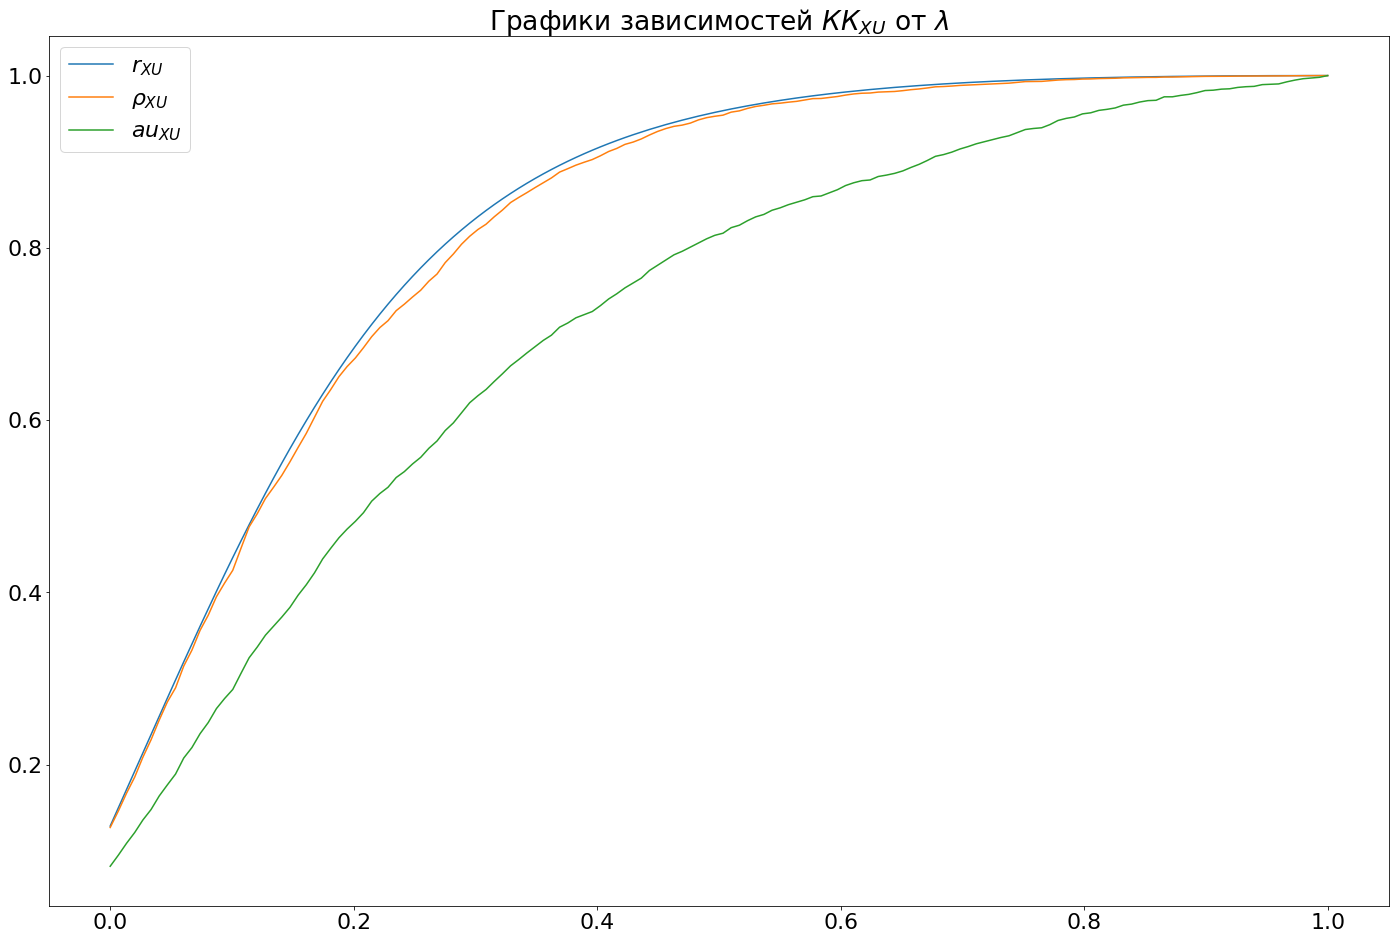

In [26]:
lambda_values = np.linspace(0, 1, 150)
def u(l, x, y):
    U = l * x.data() + (1 - l) * y.data()
    return Sample.from_data("u", U)

fig, ax = plt.subplots()
ax.set_title('Графики зависимостей $КК_{XU}$ от $\\lambda$')

pierson_values = [
    pierson(x, u(l, x, y)) for l in lambda_values
]
ax.plot(lambda_values, pierson_values, label='$r_{XU}$')

spirmen_values = [
    spirmen(x, u(l, x, y)) for l in lambda_values
]
ax.plot(lambda_values, spirmen_values, label='$\\rho_{XU}$')

kendell_values = [
    kendell(x, u(l, x, y)) for l in lambda_values
]
ax.plot(lambda_values, kendell_values, label='$\tau_{XU}$')

ax.legend();

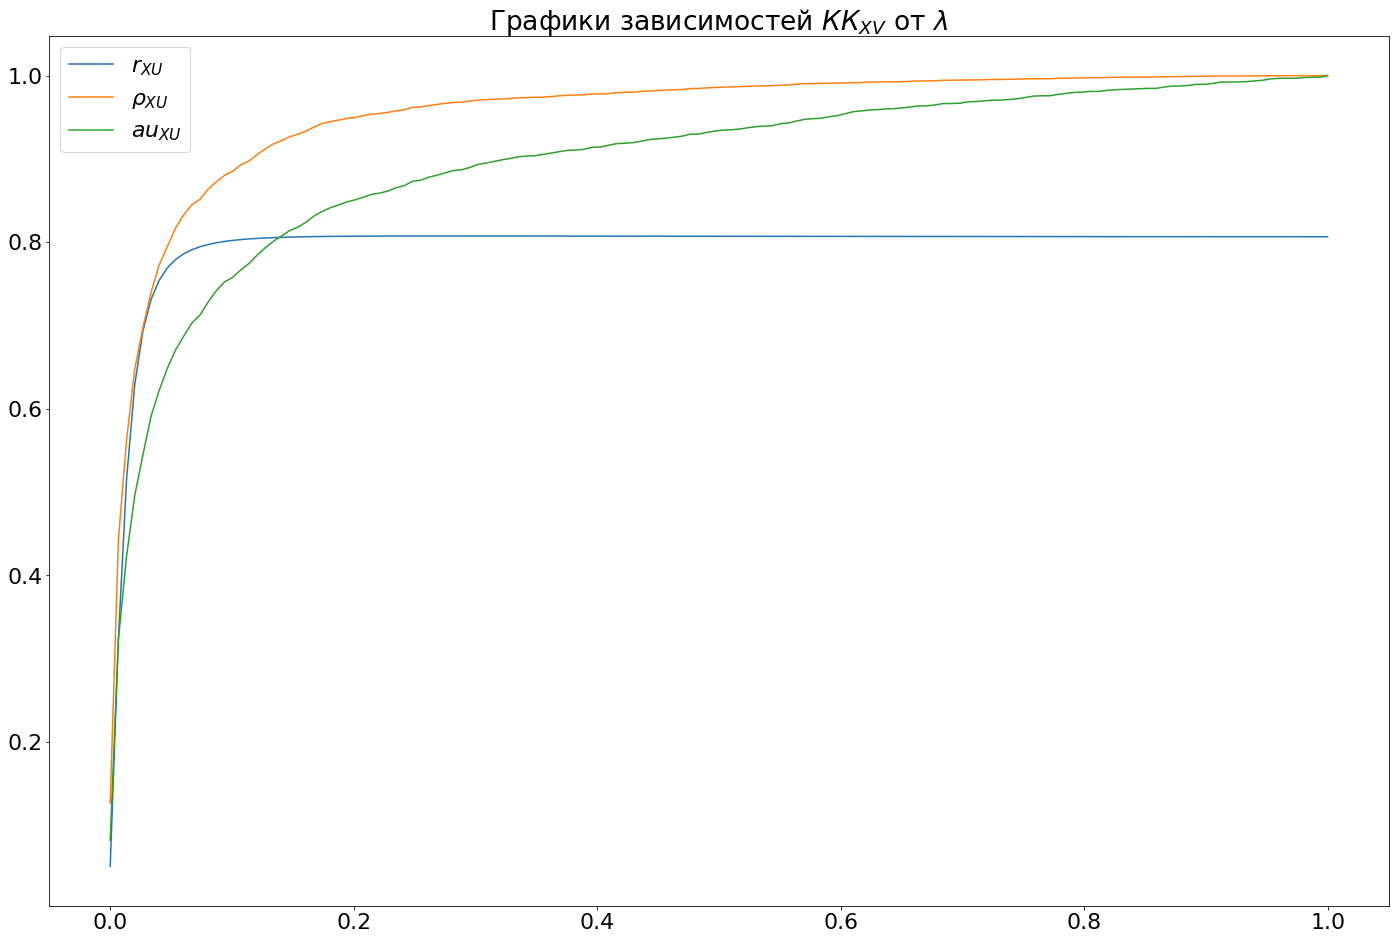

In [27]:
def v(l, x, y):
    V = l * x.data()**3 + (1 - l) * y.data()**3
    return Sample.from_data("v", V)

fig, ax = plt.subplots()
ax.set_title('Графики зависимостей $КК_{XV}$ от $\\lambda$');

pierson_values = [
    pierson(x, v(l, x, y)) for l in lambda_values
]
ax.plot(lambda_values, pierson_values, label='$r_{XU}$')

spirmen_values = [
    spirmen(x, v(l, x, y)) for l in lambda_values
]
ax.plot(lambda_values, spirmen_values, label='$\\rho_{XU}$')

kendell_values = [
    kendell(x, v(l, x, y)) for l in lambda_values
]
ax.plot(lambda_values, kendell_values, label='$\tau_{XU}$')

ax.legend();

### Выводы:

Ранговый КК - мера монотонности корреляционных связей между СВ

В соотвествии с этим: 
1. при увеличении значения $\lambda$, как и ожидалось, увеличивается значение КК
2. при $\lambda$ = 0, КК = 0, так как U(V) не зависит от X
3. при $\lambda$ = 1, КК = 1, так как U(V) функционально монотонно зависит от X

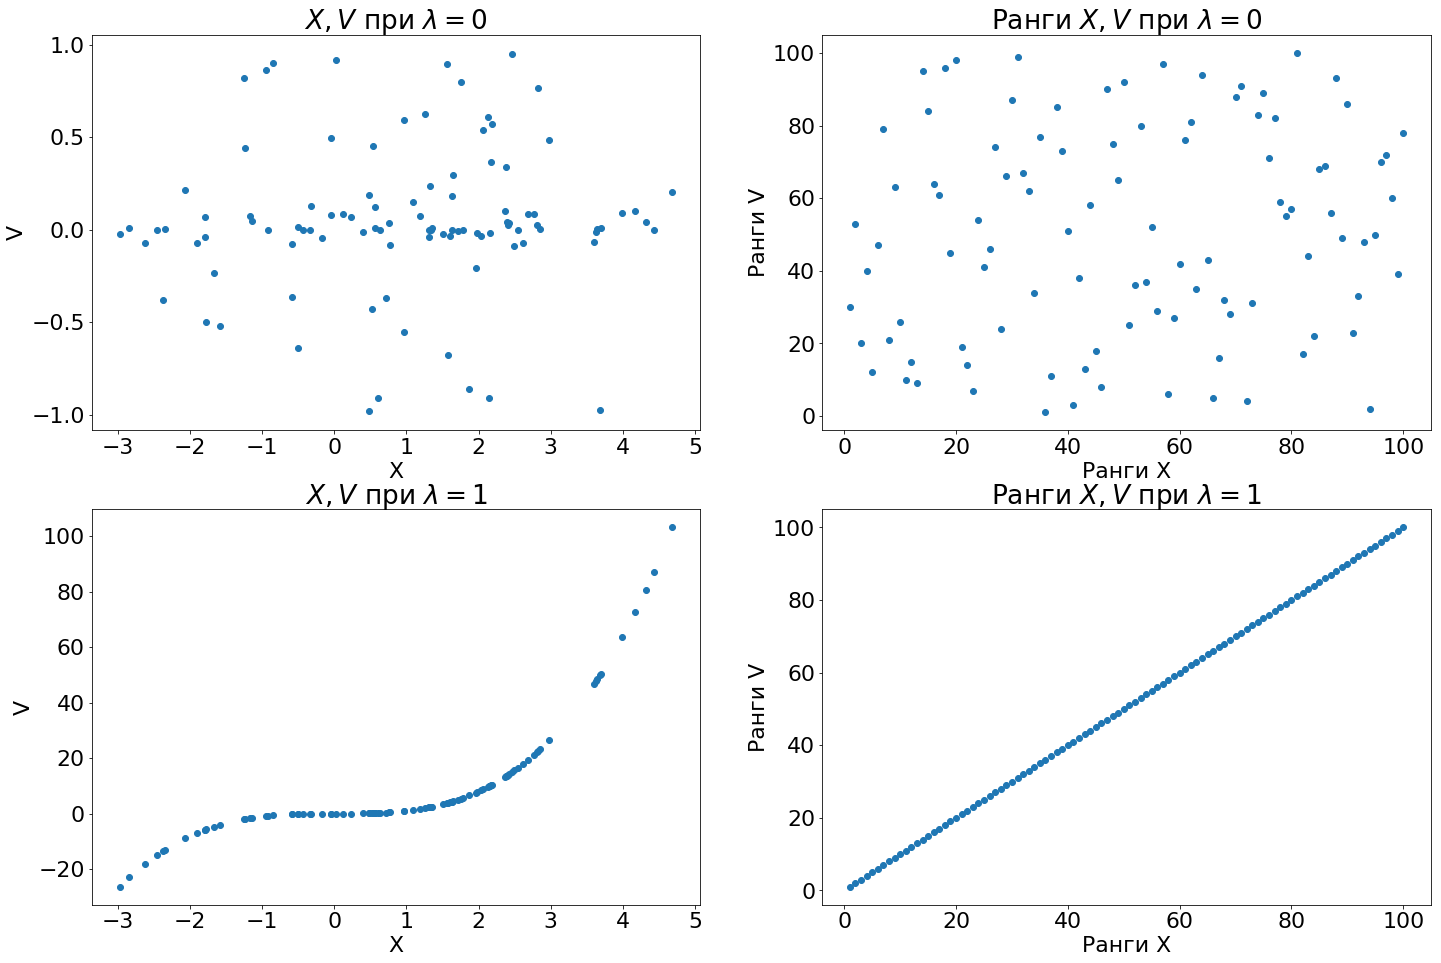

In [28]:
fig, ax = plt.subplots(2, 2)

v0 = Sample.from_data('v0', v(0, x, y).data())

ax[0][0].set_title('$X, V$ при $\\lambda = 0$')
ax[0][0].set_xlabel('X')
ax[0][0].set_ylabel('V')
ax[0][0].scatter(x.data(), v0.data())

ax[0][1].set_title('Ранги $X, V$ при $\\lambda = 0$')
ax[0][1].set_xlabel('Ранги X')
ax[0][1].set_ylabel('Ранги V')
ax[0][1].scatter(x.ranks(), v0.ranks())

v1 = Sample.from_data('v1', v(1, x, y).data())

ax[1][0].set_title('$X, V$ при $\\lambda = 1$')
ax[1][0].set_xlabel('X')
ax[1][0].set_ylabel('V')
ax[1][0].scatter(x.data(), v1.data())

ax[1][1].set_title('Ранги $X, V$ при $\\lambda = 1$')
ax[1][1].set_xlabel('Ранги X')
ax[1][1].set_ylabel('Ранги V')
ax[1][1].scatter(x.ranks(), v1.ranks());

# TODO

### Выводы:

1. При $\lambda$ = 0 не наблюдается функциональной зависимости между случайными величинами X и V, а также между их рангами
2. При $\lambda$ = 1 функциональная X и V имеет вид кубической параболы, а зависимость рангов линейна.